# Import packages needed

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import glob
import os
import re

from sklearn.metrics import classification_report, log_loss, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

# Read train dataset

In [2]:
df_train = pd.read_csv('/kaggle/input/arabic-hwr-ai-pro-intake1/train.csv')
df_train.shape

(13440, 2)

In [3]:
df_train.groupby(by='label').count()

,id
label,
1,480
2,480
3,480
4,480
5,480
6,480
7,480
8,480
9,480


In [4]:
df_train.head()

,id,label
0,0,24
1,1,2
2,2,17
3,3,14
4,4,19


In [5]:
#read images as grayscale as colors aren't actually effect in our example
images_train = [cv2.imread(file, cv2.IMREAD_GRAYSCALE) for file in 
                sorted(glob.glob("/kaggle/input/arabic-hwr-ai-pro-intake1/train/*.png"))]
images_train = np.array(images_train)
print("train images shape: {}".format(images_train.shape))

train images shape: (13440, 32, 32)


# Preprocessing train data

In [6]:
# add 1 more dimenision for images train to prepare for CNN
images_train = images_train.reshape((-1, 32, 32, 1))
print("images shape: {}".format(images_train.shape))

#preprocessing images train
images_train = images_train/255

images shape: (13440, 32, 32, 1)


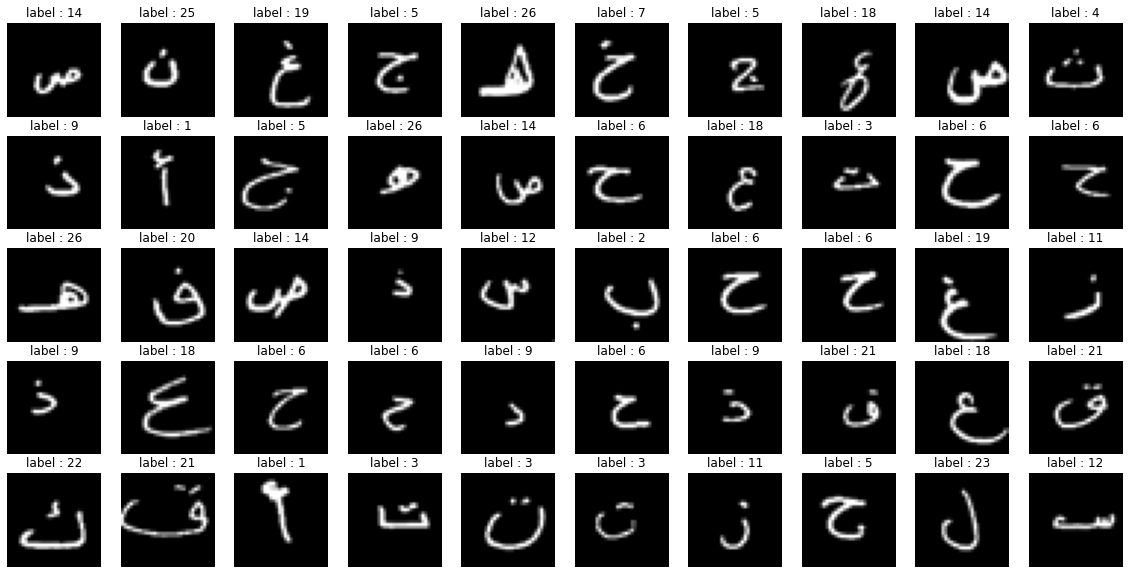

In [7]:
# show first 50 images
def display50Images(images, dataframe, random=False):
    if random == True:
        array = np.random.choice(images.shape[0], 50, replace=False)
    else:
        array = range(0,50,1)
    plt.figure(figsize=(20,10))
    j = 1
    for i in range(50):
        plt.subplot(5,10,j)
        num = array[i]
        plt.imshow(images[num], cmap='gray')
        plt.axis('off')
        plt.title('label : {}'.format(dataframe.label.iloc[num]))
        j+=1
        
display50Images(images_train, df_train, random=True)

In [8]:
#prepare y to CNN we use labelBinarizer
binencoder = LabelBinarizer()
y = binencoder.fit_transform(df_train.label.to_numpy())
print("y shape: {}".format(y.shape))
print(y[0:5])

y shape: (13440, 28)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]]


# Split train data with stratify

In [9]:
X_train, X_val, y_train, y_val = train_test_split(images_train, y,
                                                  test_size = 0.2, random_state=42, stratify= y)
print("X_train shape: {}\nX_val shape: {}".format(X_train.shape, X_val.shape))

X_train shape: (10752, 32, 32, 1)
X_val shape: (2688, 32, 32, 1)


In [10]:
#spliting X_train to validation for using in model.fit(validation_data = (X_val_2, y_val_2))
X_train_2, X_val_2, y_train_2, y_val_2 = train_test_split(X_train, y_train,
                                                  test_size = 0.2, random_state=42, stratify= y_train)
print("X_train_2 shape: {}\nX_val_2 shape: {}".format(X_train_2.shape, X_val_2.shape))

X_train_2 shape: (8601, 32, 32, 1)
X_val_2 shape: (2151, 32, 32, 1)


In [11]:
#for checking GPU specs and enable it in tensorflow
from tensorflow.python.client import device_lib
import tensorflow as tf
from tensorflow.python.keras import backend as K

print(device_lib.list_local_devices())

# adjust values to your needs
config = tf.compat.v1.ConfigProto( device_count = {'GPU': 1 , 'CPU': 8} )
sess = tf.compat.v1.Session(config=config) 
K.set_session(sess)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10532445836196248730
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 16152002560
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4414215047712391597
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
]


2021-11-07 20:59:06.976652: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-07 20:59:07.007317: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-07 20:59:07.016932: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-07 20:59:07.017729: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

# CNN model training

In [12]:
# # Example of creating a CNN model with many VGG blocks
# from keras.models import Model
# from keras.layers import Input
# from keras.layers import Conv2D
# from keras.layers import MaxPooling2D
# from keras.layers import Dense, Dropout, Flatten, BatchNormalization
# # from keras.utils.vis_utils import plot_model
 
# # function for creating a vgg block
# def vgg_block(layer_in, n_filters, n_conv):
#     # add convolutional layers
#     for _ in range(n_conv):
#         layer_in = Conv2D(n_filters, (3,3), padding='same', activation='relu',
#                           kernel_initializer='he_normal')(layer_in)
#     # add max pooling layer
#     layer_in = MaxPooling2D((2,2), strides=(2,2))(layer_in)
#     return layer_in
 
# # define model input
# visible = Input(shape=(32, 32, 1))
# # add vgg module
# layer = vgg_block(visible, 64, 2)
# # add vgg module
# layer = vgg_block(layer, 128, 2)
# # add vgg module
# layer = vgg_block(layer, 256, 4)

# layer = Flatten()(layer)

# # layer = Dense(4096,activation='relu', kernel_initializer='he_normal',kernel_regularizer='l2')(layer)
# # layer = BatchNormalization()(layer)

# layer = Dense(128,activation='relu', kernel_initializer='he_normal',kernel_regularizer='l2')(layer)
# layer = BatchNormalization()(layer)

# layer = Dense(28, activation='softmax')(layer)
# # create model
# model = Model(inputs=visible, outputs=layer)
# # summarize model
# model.summary()
# # plot model architecture
# # plot_model(model, show_shapes=True, to_file='multiple_vgg_blocks.png')

# model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [13]:
# example of a CNN model with an identity or projection residual module
from keras.models import Model
from keras.layers import Input
from keras.layers import Activation
from keras.layers import Conv2D
from keras.layers import MaxPooling2D, AveragePooling2D
from keras.layers import add
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from keras.utils.vis_utils import plot_model
 
# function for creating an identity or projection residual module
def residual_module(layer_in, n_filters):
    merge_input = layer_in
    # check if the number of filters needs to be increase, assumes channels last format
    if layer_in.shape[-1] != n_filters:
        merge_input = Conv2D(n_filters, (1,1), padding='same', activation='relu', kernel_initializer='he_normal')(layer_in)
    # conv1
    conv1 = Conv2D(n_filters, (3,3), padding='same', activation='relu', kernel_initializer='he_normal')(layer_in)
    conv1 = BatchNormalization()(conv1)
    # conv2
    conv2 = Conv2D(n_filters, (3,3), padding='same', activation='linear', kernel_initializer='he_normal')(conv1)
    conv2 = BatchNormalization()(conv2)
    # add filters, assumes filters/channels last
    layer_out = add([conv2, merge_input])
    # activation function
    layer_out = Activation('relu')(layer_out)
    return layer_out
 
# define model input
visible = Input(shape=(32, 32, 1))

# add residual module
layer = residual_module(visible, 64)
layer = residual_module(layer, 64)
layer = MaxPooling2D((2,2), strides=(2,2))(layer)

layer = residual_module(layer, 128)
layer = residual_module(layer, 128)
layer = MaxPooling2D((2,2), strides=(2,2))(layer)

layer = residual_module(layer, 256)
layer = residual_module(layer, 256)

# add average pool
layer = AveragePooling2D(pool_size=(2, 2), strides=(2,2))(layer)

# add faltten
layer = Flatten()(layer)

# layer = Dense(128,activation='relu', kernel_initializer='he_normal',kernel_regularizer='l2')(layer)
# layer = BatchNormalization()(layer)

layer = Dense(28, activation='softmax')(layer)

# create model
model = Model(inputs=visible, outputs=layer)
# summarize model
model.summary()
# plot model architecture
plot_model(model, show_shapes=True, to_file='residual_module.png')

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

2021-11-07 21:00:01.563932: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-07 21:00:01.564918: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-07 21:00:01.565708: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-07 21:00:01.566706: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-07 21:00:01.567482: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 64)   640         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 64)   256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 32, 32, 64)   36928       batch_normalization[0][0]        
______________________________________________________________________________________________

In [14]:
# data augementation using model.fit_generator()
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        featurewise_center=False, 
        samplewise_center=False,  
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=10,
        zoom_range = 0.1,  
        width_shift_range=0.1, 
        height_shift_range=0.1,
        horizontal_flip=False,
        vertical_flip=False)
datagen.fit(X_train_2)

In [15]:
# We will import a call back to save the best epoch's weights
from tensorflow.keras.callbacks import ModelCheckpoint                                     

checkpointer = ModelCheckpoint(filepath='weights.hdf5', verbose=1,
                               monitor='val_accuracy', mode='max', save_best_only=True)

# hist = model.fit(X_train, y_train, validation_split=0.2, epochs=200,
#                  batch_size=32, callbacks=[checkpointer])

# hist = model.fit(X_train_2, y_train_2, validation_data=(X_val_2, y_val_2), epochs=200,
#                  batch_size=32, callbacks=[checkpointer])

# fit_generator for dataImageGenerator...
batchSize = 64
hist = model.fit_generator(datagen.flow(X_train_2, y_train_2, batch_size=batchSize),
                           epochs = 200, steps_per_epoch=X_train_2.shape[0] // batchSize,
                           validation_data=(X_val_2, y_val_2), callbacks=[checkpointer])

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2021-11-07 21:00:46.342594: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/200


2021-11-07 21:00:48.042272: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


134/134 [==============================] - 8s 39ms/step - loss: 2.6281 - accuracy: 0.4900 - val_loss: 3.9349 - val_accuracy: 0.1371

Epoch 00001: val_accuracy improved from -inf to 0.13715, saving model to weights.hdf5


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/200
134/134 [==============================] - 5s 34ms/step - loss: 0.5023 - accuracy: 0.8434 - val_loss: 4.9712 - val_accuracy: 0.1720

Epoch 00002: val_accuracy improved from 0.13715 to 0.17201, saving model to weights.hdf5
Epoch 3/200
134/134 [==============================] - 4s 32ms/step - loss: 0.3413 - accuracy: 0.8980 - val_loss: 0.8680 - val_accuracy: 0.7146

Epoch 00003: val_accuracy improved from 0.17201 to 0.71455, saving model to weights.hdf5
Epoch 4/200
134/134 [==============================] - 4s 33ms/step - loss: 0.2595 - accuracy: 0.9193 - val_loss: 0.5335 - val_accuracy: 0.8317

Epoch 00004: val_accuracy improved from 0.71455 to 0.83171, saving model to weights.hdf5
Epoch 5/200
134/134 [==============================] - 4s 31ms/step - loss: 0.2311 - accuracy: 0.9303 - val_loss: 0.6850 - val_accuracy: 0.8215

Epoch 00005: val_accuracy did not improve from 0.83171
Epoch 6/200
134/134 [==============================] - 4s 32ms/step - loss: 0.2153 - accuracy: 0.9

# Model evaluation over validation data

In [16]:
# Loading the best weights
model.load_weights('weights.hdf5')   

# training accuracy of our model
print("training accuracy: {}".format(model.evaluate(X_train_2, y_train_2)))

# Evaluating our model
print("validation accuracy: {}".format(model.evaluate(X_val, y_val)))

269/269 [==============================] - 2s 6ms/step - loss: 0.0011 - accuracy: 0.9998
training accuracy: [0.0010554310865700245, 0.9997674822807312]
84/84 [==============================] - 1s 6ms/step - loss: 0.1299 - accuracy: 0.9836
validation accuracy: [0.129909485578537, 0.9836309552192688]


In [17]:
y_pred = model.predict(X_val)
pred = np.argmax(y_pred, axis=1) + 1 
ground = np.argmax(y_val, axis=1) + 1

print(classification_report(ground,pred))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        96
           2       0.98      1.00      0.99        96
           3       0.98      0.93      0.95        96
           4       0.96      0.98      0.97        96
           5       0.98      1.00      0.99        96
           6       0.97      0.99      0.98        96
           7       1.00      0.96      0.98        96
           8       0.98      0.95      0.96        96
           9       0.96      1.00      0.98        96
          10       0.95      0.99      0.97        96
          11       1.00      0.96      0.98        96
          12       0.99      1.00      0.99        96
          13       1.00      1.00      1.00        96
          14       0.99      0.99      0.99        96
          15       1.00      0.99      0.99        96
          16       0.98      0.98      0.98        96
          17       0.99      0.98      0.98        96
          18       0.95    

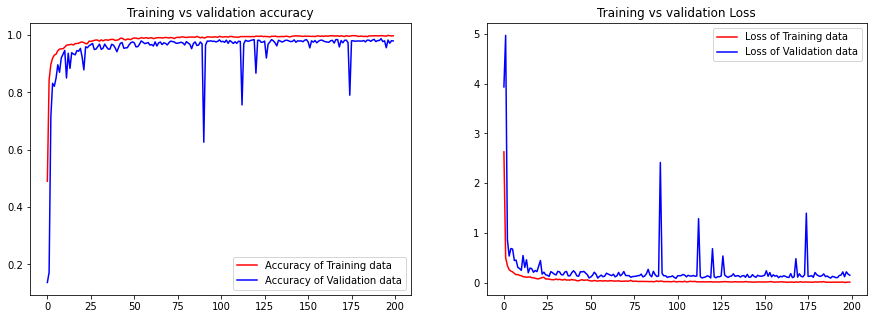

In [18]:
get_acc = hist.history['accuracy']
value_acc = hist.history['val_accuracy']
get_loss = hist.history['loss']
validation_loss = hist.history['val_loss']


epochs = range(len(get_acc))
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(epochs, get_acc, 'r', label='Accuracy of Training data')
plt.plot(epochs, value_acc, 'b', label='Accuracy of Validation data')
plt.title('Training vs validation accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, get_loss, 'r', label='Loss of Training data')
plt.plot(epochs, validation_loss, 'b', label='Loss of Validation data')
plt.title('Training vs validation Loss')
plt.legend()

plt.show()

# Read test data

In [19]:
#read images as grayscale as colors aren't actually effect in our example
images_test = [cv2.imread(file, cv2.IMREAD_GRAYSCALE) for file in 
                sorted(glob.glob("/kaggle/input/arabic-hwr-ai-pro-intake1/test/*.png"))]
images_test = np.array(images_test)
print("train images shape: {}".format(images_test.shape))

train images shape: (3360, 32, 32)


In [20]:
# add 1 more dimenision for images train to prepare for CNN
images_test = images_test.reshape((-1, 32, 32, 1))
print("images shape: {}".format(images_test.shape))

#preprocessing images train
images_test = images_test/255

images shape: (3360, 32, 32, 1)


# Predict label of test data

In [21]:
imagesName_test = [re.sub(r'\D', "",os.path.basename(file)) for file in 
                   sorted(glob.glob("/kaggle/input/arabic-hwr-ai-pro-intake1/test/*.png"))]
df_test = pd.DataFrame(imagesName_test,columns=["id"])

y_pred_test = model.predict(images_test)
df_test["label"] = np.argmax(y_pred_test, axis=1) + 1

df_test.head()

,id,label
0,00000,26
1,00001,10
2,00002,1
3,00003,10
4,00004,15


# Display random images of test after predictions

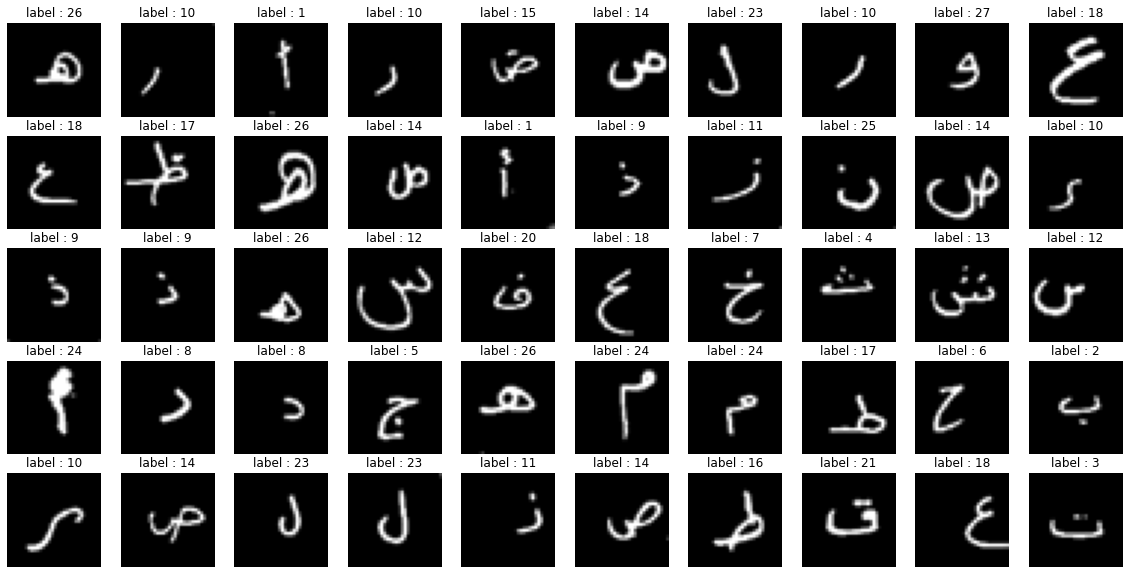

In [22]:
# show first 50 images
display50Images(images_test, df_test)

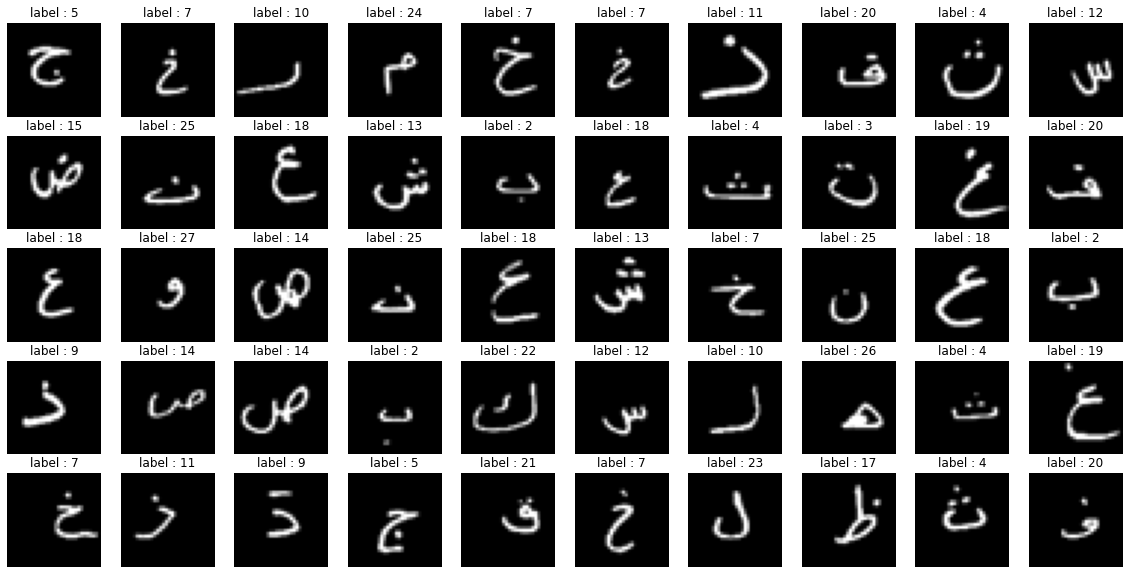

In [23]:
# show first 50 images
display50Images(images_test, df_test, random=True)

In [24]:
df_test[['id', 'label']].to_csv('submission.csv', index=False)